In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import category_encoders as ce
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

#task 2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from numpy.linalg import inv
# task 3 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Задание 1 : Байесовская классификация

### Открываем в Pandas файл names.csv

In [2]:
data = pd.read_csv("names.csv")
data

,year,name,percent,sex
0,1880,John,0.081541,boy
1,1880,William,0.080511,boy
2,1880,James,0.050057,boy
3,1880,Charles,0.045167,boy
4,1880,George,0.043292,boy
...,...,...,...,...
257995,2008,Carleigh,0.000128,girl
257996,2008,Iyana,0.000128,girl
257997,2008,Kenley,0.000127,girl
257998,2008,Sloane,0.000127,girl


### Разделим данные в выборке на обучающий набор и тестирование 

In [3]:
y=data.sex
X=data.name
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

samples = np.stack((X_train.to_numpy(),y_train.to_numpy()),axis=-1)

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

### Обучить наивную байесовскую классификацию из файла Sem2.ipynb) на тренировочном наборе данных...ных

In [4]:
from collections import defaultdict
from collections import Counter
from math import log

def train(samples):
    fech = [get_features(feat) for feat,label in samples]
    uniq = len(Counter(fech))           # количество уникальных фичей
    ans = [label for feat, label in samples]
    sampl = list()
    for i in range(len(ans)):
        sampl.append((fech[i], ans[i]))
    
    uniq = len(Counter(sampl))           # количество уникальных фичей

    boy_feat = list()
    girl_feat = list()

    classes, freq = defaultdict(lambda:0), defaultdict(lambda:0)
    for feats, label in sampl:
        classes[label] += 1                 # count classes frequencies
        for feat in feats:
            freq[label, feat] += 1          # count features frequencies

    boy_feat = list()
    girl_feat = list()

    exists_feat = list(freq.keys())

    for i in range(len(exists_feat)):
        lab, fet = exists_feat[i]
        if lab == 'boy':
             boy_feat.append(fet)
        if lab == 'girl':
             girl_feat.append(fet)

    n_b = len(boy_feat)
    for i in range(n_b):
        if boy_feat[i] not in girl_feat:
            freq['girl', boy_feat[i]] = 0
            girl_feat.append(boy_feat[i])

    n_g = len(girl_feat)
    for i in range(n_g):
        if girl_feat[i] not in boy_feat:
            freq['boy', girl_feat[i]] = 0
            girl_feat.append(girl_feat[i])

    for label, feat in freq:                # normalize features frequencies
        freq[label, feat] = (freq[label, feat] +1)/ (classes[label]+uniq)

    sum_g,sum_b = 0,0
    for  label, feat in freq:
        if label=='girl':
            sum_g += freq[label, feat]
        if label=='boy':
            sum_b += freq[label, feat]    

    freq['girl', 'new'] = 1 - sum_g
    freq['boy', 'new'] = 1 - sum_b    
    
    for c in classes:                       # normalize classes frequencies
        classes[c] /= len(sampl)
    print(classes, freq)
    return classes, freq                    # return P(C) and P(O|C)

def classify(classifier, feats):
    classes, prob = classifier
    exists = list(prob.keys())
    exs = list()
    for i in range(len(exists)):
        label,fets = exists[i]
        exs.append(fets)

    if feats not in exs:
        feats = 'new'
        
    return min(classes.keys(),              # calculate argmin(-log(P(C|O))) -> argmax(P(C|O))
        key = lambda cl: -log(classes[cl]) + \
            sum(-log(prob.get((cl,feat))) for feat in feats))

def get_features(sample): return (sample[-1]) # get last letter


classifier = train(samples)

defaultdict(<function train.<locals>.<lambda> at 0x000001C7A8F4D280>, {'boy': 0.5004223070693047, 'girl': 0.49957769293069537}) defaultdict(<function train.<locals>.<lambda> at 0x000001C7A8F4D310>, {('boy', 'n'): 0.21326154521611534, ('girl', 'e'): 0.3016376367108385, ('girl', 'h'): 0.024917539494242233, ('boy', 'r'): 0.06041524650206237, ('boy', 'm'): 0.01607144920335987, ('boy', 'k'): 0.022252775820036742, ('girl', 'a'): 0.382570453098779, ('boy', 'c'): 0.009497290614782036, ('boy', 'y'): 0.1113216485078162, ('girl', 'r'): 0.012001620276604364, ('girl', 'n'): 0.08063190787570164, ('boy', 'b'): 0.003870550311377107, ('boy', 'e'): 0.13908562581599287, ('girl', 's'): 0.022012615010705398, ('boy', 'w'): 0.004933507411814999, ('boy', 'l'): 0.08255248350683413, ('boy', 'd'): 0.07256992986793913, ('boy', 't'): 0.052847454102205635, ('boy', 'x'): 0.0044597982692285475, ('boy', 'i'): 0.005314785502189461, ('boy', 'p'): 0.003281302353525667, ('boy', 's'): 0.07843930168340053, ('girl', 'y'): 0.

In [5]:
y_predition = np.zeros_like(X_test)
for i in range(len(X_test)):
    name = X_test[i]
    y_predition[i] = classify(classifier, get_features(name))
    print(i, name, classify(classifier, get_features(u'{}'.format(name))))

0 Alexia girl
1 Kailey boy
2 Alexandra girl
3 Ellsworth boy
4 Laurel boy
5 Gay boy
6 Sedrick boy
7 Erlene girl
8 Louann boy
9 Lavern boy
10 Terri girl
11 Augustine girl
12 Duncan boy
13 Reid boy
14 Dwight boy
15 Nolan boy
16 Wilburn boy
17 India girl
18 Raphael boy
19 Adell boy
20 Retta girl
21 Newman boy
22 Wally boy
23 Norene girl
24 Desirae girl
25 Ramon boy
26 Wilford boy
27 Mervin boy
28 Sherman boy
29 Tanisha girl
30 Olive girl
31 William boy
32 Danyelle girl
33 Una girl
34 Jolene girl
35 Lee girl
36 Coleen boy
37 Jannie girl
38 Idella girl
39 Monica girl
40 Brendan boy
41 Alonso boy
42 Chance girl
43 Earl boy
44 Luis boy
45 Tariq boy
46 Darla girl
47 Elliott boy
48 Kitty boy
49 Sherie girl
50 Maxie girl
51 Freddy boy
52 Kyra girl
53 Constantine girl
54 Lupe girl
55 Jarrett boy
56 Finley boy
57 Mina girl
58 Rodger boy
59 Hilliard boy
60 Rosamond boy
61 Eldridge girl
62 Jeromy boy
63 Sidney boy
64 Nancy boy
65 Cathrine girl
66 Hans boy
67 Gordon boy
68 Bronson boy
69 Danelle girl


## Посчитайте среднюю долю правильных "ответов"классификатора. Какие еще метрики можно построить, чтобы оценить, насколько хорошо справился с задачей данный классификатор

Для оценки бинарного классификатора можно использовать такие оценки как 

Accuracy - доля объектов, для которых мы правильно предсказали класс

Confusion matrix - количество верных положительных и отрицательных ответов, ошибок первого и второго рода 

Precision - долю правильно предсказанных положительных объектов среди всех объектов, предсказанных положительным классом

Recall -  доля правильно найденных положительных объектов среди всех объектов положительного класс

Также можно построить auc roc

In [6]:
y_t = np.zeros((len(y_test)))
y_pr = np.zeros((len(y_test)))

for i in range(len(y_test)):
    if y_test[i] == 'boy':
        y_t[i] = 1

    if y_predition[i] == 'boy':
        y_pr[i] = 1
        
y_pr = y_pr.astype(int)
y_t = y_t.astype(int)

In [7]:
print("Accuracy Score : {:.3f}".format(accuracy_score(y_t, y_pr)))
print("Confusion matrix : \n",confusion_matrix(y_t, y_pr))
print("Precision : {:.3f}".format(precision_score(y_t, y_pr)))
print("Recall:" , recall_score(y_t, y_pr))
print("F_1:" , f1_score(y_t, y_pr))
print ('Roc-auc score: \n', roc_auc_score(y_t, y_pr))

Accuracy Score : 0.780
Confusion matrix : 
 [[30631 12012]
 [ 6728 35769]]
Precision : 0.749
Recall: 0.8416829423253406
F_1: 0.7924189725071447
Roc-auc score: 
 0.7799977218954985


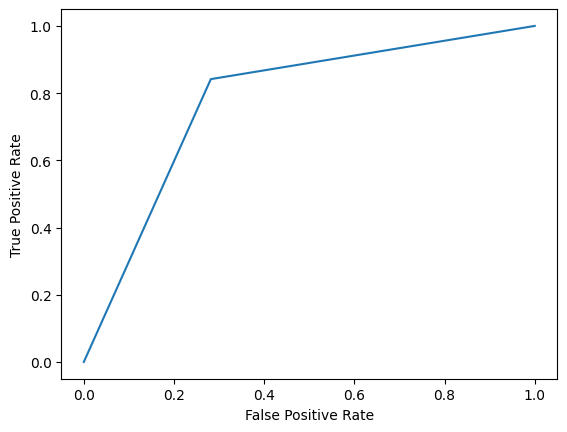

In [8]:
fpr, tpr, _ = roc_curve(y_t, y_pr)

#create ROC curve
plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

## Модифицируйте функцию get_features() таким образом, чтобы в качестве целевого признака бралась другая структура (не последняя буква имени). Возможно, это будет набор из первой и последней буквы. Или, например, имя целиком..

Допустим, что берем первую и последнюю буквы имени в качестве целевого признака....

In [9]:
def get_features_name(sample):
    l = len(sample)
    return sample[0::l-1]

In [10]:
def train_name(samples):
    fech = [get_features_name(feat) for feat, label in samples]
    ans = [label for feat, label in samples]
    sampl = list()
    for i in range(len(ans)):
        sampl.append((fech[i], ans[i]))
    uniq = len(Counter(sampl))# количество уникальных фичей

    boy_feat = list()
    girl_feat = list()

    classes, freq = defaultdict(lambda:0), defaultdict(lambda:0)
    for feats, label in sampl:
        classes[label] += 1                 # count classes frequencies
        for feat in feats:
            freq[label, feat] += 1          # count features frequencies

    boy_feat = list()
    girl_feat = list()

    exists_feat = list(freq.keys())

    for i in range(len(exists_feat)):
        lab, fet = exists_feat[i]
        if lab == 'boy':
             boy_feat.append(fet)
        if lab == 'girl':
             girl_feat.append(fet)

    n_b = len(boy_feat)
    for i in range(n_b):
        if boy_feat[i] not in girl_feat:
            freq['girl', boy_feat[i]] = 0
            girl_feat.append(boy_feat[i])

    n_g = len(girl_feat)
    for i in range(n_g):
        if girl_feat[i] not in boy_feat:
            freq['boy', girl_feat[i]] = 0
            girl_feat.append(girl_feat[i])

    for label, feat in freq:                # normalize features frequencies
        freq[label, feat] = (freq[label, feat] +1)/ (classes[label]+uniq)

    sum_g,sum_b = 0,0
    for  label, feat in freq:
        if label=='girl':
            sum_g += freq[label, feat]
        if label=='boy':
            sum_b += freq[label, feat]    

    freq['girl', 'new'] = 1 - sum_g
    freq['boy', 'new'] = 1 - sum_b    
    
    for c in classes:                       # normalize classes frequencies
        classes[c] /= len(sampl)
    print(classes, freq)
    return classes, freq                    # return P(C) and P(O|C)

def classify(classifier, feats):
    classes, prob = classifier
    exists = list(prob.keys())
    exs = list()
    for i in range(len(exists)):
        label,fets = exists[i]
        exs.append(fets[0])

    for i in range(len(feats)):
        if feats[i] not in exs:
            feats[i] = 'new'
        
    return min(classes.keys(),              # calculate argmin(-log(P(C|O))) -> argmax(P(C|O))
        key = lambda cl: -log(classes[cl]) + \
            sum(-log(prob.get((cl,feat))) for feat in feats))



classifier = train_name(samples)

defaultdict(<function train_name.<locals>.<lambda> at 0x000001C7A8F4D160>, {'boy': 0.5004223070693047, 'girl': 0.49957769293069537}) defaultdict(<function train_name.<locals>.<lambda> at 0x000001C7A8F4D0D0>, {('boy', 'I'): 0.01610756734431646, ('boy', 'n'): 0.21176173649671884, ('girl', 'R'): 0.04818543289894045, ('girl', 'e'): 0.2995127444896458, ('girl', 'C'): 0.08192557861591855, ('girl', 'F'): 0.020777310441517847, ('girl', 'h'): 0.02474200740076766, ('girl', 'E'): 0.06697464892321128, ('boy', 'D'): 0.07356247992290395, ('boy', 'W'): 0.03636822541416181, ('boy', 'r'): 0.05999036299389656, ('boy', 'T'): 0.039534670276719745, ('boy', 'm'): 0.015958423202239457, ('boy', 'F'): 0.026914781331742462, ('boy', 'k'): 0.022096278280023862, ('girl', 'A'): 0.09141786756762968, ('girl', 'a'): 0.37987542807235286, ('girl', 'B'): 0.041416718380105265, ('girl', 'H'): 0.023225079868532946, ('boy', 'A'): 0.08208664127392043, ('girl', 'Y'): 0.004539290721459928, ('boy', 'E'): 0.06558900463494104, ('b

In [11]:
y_predition = np.zeros_like(X_test)
for i in range(len(X_test)):
    name = X_test[i]
    y_predition[i] = classify(classifier, get_features_name(name))
    #print(i, name, classify(classifier, get_features(u'{}'.format(name))))

In [12]:
y_t = np.zeros((len(y_test)))
y_pr = np.zeros((len(y_test)))

for i in range(len(y_test)):
    if y_test[i] == 'boy':
        y_t[i] = 1

    if y_predition[i] == 'boy':
        y_pr[i] = 1
        
y_pr = y_pr.astype(int)
y_t = y_t.astype(int)

In [13]:
print("Accuracy Score : {:.3f}".format(accuracy_score(y_t, y_pr)))
print("Confusion matrix : \n",confusion_matrix(y_t, y_pr))
print("Precision : {:.3f}".format(precision_score(y_t, y_pr)))
print("Recall:" , recall_score(y_t, y_pr))
print("F_1:" , f1_score(y_t, y_pr))
print ('Roc-auc score: \n', roc_auc_score(y_t, y_pr))

Accuracy Score : 0.783
Confusion matrix : 
 [[32038 10605]
 [ 7829 34668]]
Precision : 0.766
Recall: 0.81577523119279
F_1: 0.7899737951464053
Roc-auc score: 
 0.7835412984986299


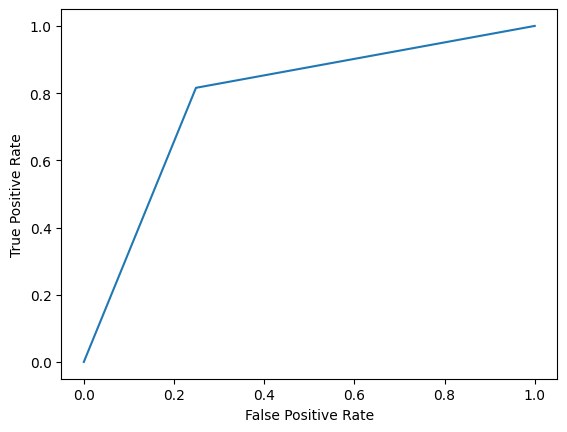

In [14]:
fpr, tpr, _ = roc_curve(y_t, y_pr)

#create ROC curve
plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

## Модифицируйте метод classify() так, чтобы вместо логарифмов брались исходные значения вероятностей, а вместо argmin(...) считался функционал argmax(...). Также можете использовать другой метод классификации (из лекций или учебников, или модифицировать его самому методом проб и ошибок).

In [15]:
def train(samples):
    fech = [get_features(feat) for feat,label in samples]
    ans = [label for feat, label in samples]
    sampl = list()
    for i in range(len(ans)):
        sampl.append((fech[i], ans[i]))
    
    uniq = len(Counter(sampl))           # количество уникальных фичей

    boy_feat = list()
    girl_feat = list()

    classes, freq = defaultdict(lambda:0), defaultdict(lambda:0)
    for feats, label in sampl:
        classes[label] += 1                 # count classes frequencies
        for feat in feats:
            freq[label, feat] += 1          # count features frequencies

    boy_feat = list()
    girl_feat = list()

    exists_feat = list(freq.keys())

    for i in range(len(exists_feat)):
        lab, fet = exists_feat[i]
        if lab == 'boy':
             boy_feat.append(fet)
        if lab == 'girl':
             girl_feat.append(fet)

    n_b = len(boy_feat)
    for i in range(n_b):
        if boy_feat[i] not in girl_feat:
            freq['girl', boy_feat[i]] = 0
            girl_feat.append(boy_feat[i])

    n_g = len(girl_feat)
    for i in range(n_g):
        if girl_feat[i] not in boy_feat:
            freq['boy', girl_feat[i]] = 0
            girl_feat.append(girl_feat[i])

    for label, feat in freq:                # normalize features frequencies
        freq[label, feat] = (freq[label, feat] +1)/ (classes[label]+uniq)

    sum_g,sum_b = 0,0
    for  label, feat in freq:
        if label=='girl':
            sum_g += freq[label, feat]
        if label=='boy':
            sum_b += freq[label, feat]    

    freq['girl', 'new'] = 1 - sum_g
    freq['boy', 'new'] = 1 - sum_b    
    
    for c in classes:                       # normalize classes frequencies
        classes[c] /= len(sampl)
    print(classes, freq)
    return classes, freq                    # return P(C) and P(O|C)

def classify_new(classifier, feats):
    classes, prob = classifier
    exists = list(prob.keys())
    exs = list()
    for i in range(len(exists)):
        label,fets = exists[i]
        exs.append(fets)

    if feats not in exs:
        feats = 'new'
        
    return max(classes.keys(),              # calculate argmin(-log(P(C|O))) -> argmax(P(C|O))
        key = lambda cl: classes[cl] * \
            math.prod(prob.get((cl,feat)) for feat in feats))

def get_features(sample): return (sample[-1]) # get last letter


classifier = train(samples)

defaultdict(<function train.<locals>.<lambda> at 0x000001C7A8F4D1F0>, {'boy': 0.5004223070693047, 'girl': 0.49957769293069537}) defaultdict(<function train.<locals>.<lambda> at 0x000001C7AB719160>, {('boy', 'n'): 0.21326154521611534, ('girl', 'e'): 0.3016376367108385, ('girl', 'h'): 0.024917539494242233, ('boy', 'r'): 0.06041524650206237, ('boy', 'm'): 0.01607144920335987, ('boy', 'k'): 0.022252775820036742, ('girl', 'a'): 0.382570453098779, ('boy', 'c'): 0.009497290614782036, ('boy', 'y'): 0.1113216485078162, ('girl', 'r'): 0.012001620276604364, ('girl', 'n'): 0.08063190787570164, ('boy', 'b'): 0.003870550311377107, ('boy', 'e'): 0.13908562581599287, ('girl', 's'): 0.022012615010705398, ('boy', 'w'): 0.004933507411814999, ('boy', 'l'): 0.08255248350683413, ('boy', 'd'): 0.07256992986793913, ('boy', 't'): 0.052847454102205635, ('boy', 'x'): 0.0044597982692285475, ('boy', 'i'): 0.005314785502189461, ('boy', 'p'): 0.003281302353525667, ('boy', 's'): 0.07843930168340053, ('girl', 'y'): 0.

In [16]:
y_predition = np.zeros_like(X_test)
for i in range(len(X_test)):
    name = X_test[i]
    y_predition[i] = classify_new(classifier, get_features(name))
    #print(i, name, classify(classifier, get_features(u'{}'.format(name))))

## Улучшилась ли доля правильных ответов алгоритма после модификации целевого признака и метода classify()? Какие выводы можно сделать о выборе целевых признаков и о влиянии классифицирующей функции на результат алгоритма?

In [17]:
print("Accuracy Score : {:.3f}".format(accuracy_score(y_t, y_pr)))
print("Confusion matrix : \n",confusion_matrix(y_t, y_pr))
print("Precision : {:.3f}".format(precision_score(y_t, y_pr)))
print("Recall:" , recall_score(y_t, y_pr))
print("F_1:" , f1_score(y_t, y_pr))
print ('Roc-auc score: \n', roc_auc_score(y_t, y_pr))

Accuracy Score : 0.783
Confusion matrix : 
 [[32038 10605]
 [ 7829 34668]]
Precision : 0.766
Recall: 0.81577523119279
F_1: 0.7899737951464053
Roc-auc score: 
 0.7835412984986299


Можно заметить, что доля правильных ответов алгортма незначительно улучшилась после модификаций. Чем больше выбрано целевых признаков, тем модель лучше предсказывает. 

Теоретически, классицфицирующая функция в данном случае ничего не должна менять, ведь при использовании argmin вычислялся -log (который является монотонной функцией) от того, что было посчитано в функции argmax. Но при произведении маленьких чисел есть вероятность "вылезти" за погрешность и тогда результаты модели ухудшатся.  


## Запустите гауссовский и мультиномиальный классификатор методами из sklearn.naive_bayes. Насколько точна классификация в данном случае? Какой из трех методов оказался точнее (наивный, гауссовский или мультиномиальный)?

In [18]:
y=data.sex
X=data.name
X=X.str[-1]
X

0         n
1         m
2         s
3         s
4         e
         ..
257995    h
257996    a
257997    y
257998    e
257999    a
Name: name, Length: 258000, dtype: object

In [19]:
import category_encoders as ce
encoder = ce.OneHotEncoder(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
X_train_code = encoder.fit_transform(X_train)
X_test_code = encoder.transform(X_test)

### Наивный гауссовский Байес

In [22]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train_code, y_train).predict(X_test_code)
print("Accuracy Score : {:.3f}".format(accuracy_score(y_test, y_pred)))

Accuracy Score : 0.596


In [23]:
#for i in range(15):
#    print(y_test.to_numpy()[i],y_pred[i])

In [24]:
from sklearn.feature_extraction.text import HashingVectorizer
y=data.sex
X=data.name
vectorizer = HashingVectorizer(n_features = 2**9)
X_ha = vectorizer.fit_transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X_ha, y, test_size=0.33, random_state=42)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Accuracy Score : {:.3f}".format(accuracy_score(y_test, y_pred)))

Accuracy Score : 0.645


### Мультиномиальный байесовский классификатор

In [25]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train_code, y_train)
y_pred = clf.predict(X_test_code)
print("Accuracy Score :", accuracy_score(y_test, y_pred))

Accuracy Score : 0.7798919426826404


Cреди опробованных готовых классификаторов лучше всех себя показал мультиномиальный. 

Вообще, стоит обратить внимание как давнные передаются в классификатор - при различных способах получается по разному

Все результаты тут были получепны для последней букв имени 

# Задание 2: Классификация ирисов

## Теперь возьмем датасет, содержащий описание цветков ириса и их классификацию по сортам (Setosa, Versicolour, Virginica). Этот набор данных содержится в sklearn.datasets.load_iris().

In [26]:
data = load_iris()
feature_names = data.feature_names

## Разделите данные на обучение и тестировку (аналогично заданию 1);

In [27]:
y=data.target
X=data.data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#data.target_names

## С помощью метода LDA (линейный дискриминантный анализ) реализуйте классификацию сортов ириса на основании признаков датасета;

### Реализация с помощью встроенных LinearDiscriminantAnalysis

In [28]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [29]:
y_pred = clf.predict(X_test)

### Реализация "ручками"

Построи модель, на основании которой будут "предсказываться результаты"

In [30]:
def LDA_model(X, y):
    '''
    X - набор данных, y - метка, k - целевой размер
    '''
    label_ = list(set(y))
    n = len(X[0]) # изначальное количество признаков

    X_classify = {}
    for label in label_:
        X1 = np.array([X[i] for i in range(len(X)) if y[i] == label])
        X_classify[label] = X1
        
    # находим центроиды или среднее значение по классам
    mju = np.mean(X, axis=0) # общее среднее
    mju_classify = np.zeros((len(label_),n))

    for i in range(len(label_)):
        mju1 = np.mean(X_classify[i], axis=0) #центроиды
        mju_classify[i] = mju1
        
        
    priors = np.zeros(len(label_))
                             
    for i in range(len(label_)):
        priors[i] = len(X_classify[i])/len(X)
        
    #St = np.dot((X - mju).T, X - mju)

    Sw = np.zeros((len(mju), len(mju)))  # Вычислить матрицу внутриклассовой дивергенции
    for i in label_:
        Sw += np.dot((X_classify[i] - mju_classify[i]).T,
                     X_classify[i] - mju_classify[i])

    Sb = np.zeros((len(mju), len(mju)))  # Вычислить матрицу межклассовой дивергенции
    for i in label_:
        Sb += len(X_classify[i]) * np.dot((mju_classify[i] - mju).reshape(
            (len(mju), 1)), (mju_classify[i] - mju).reshape((1, len(mju))))
    
    model = [priors, mju, mju_classify, Sw, label_ ]
    return model

In [31]:
def LDA_class(model, x):
    priors, mju, mju_classify, Sw, label_ = model
    y = np.zeros((len(x)))
    delt = np.zeros((len(x),len(label_)))
    for i in range(len(x)):
        for j in range(len(label_)):
            delt[i][j] = (x[i])@(np.linalg.inv(Sw))@mju_classify[j]-1/2*np.transpose(mju_classify[j])@np.linalg.inv(Sw)@np.transpose(mju_classify[j])+np.log(priors[j])
    y = np.argmax(delt,axis=1)
    return y
        

In [32]:
model = LDA_model(X_train, y_train)

In [33]:
y_pred1 = LDA_class(model, X_test)

## По метрикам из задания 1 оцените эффективность классификатора;

Метриками, по которым можно определить качество классификатора являются:

Accuracy - доля объектов, для которых мы правильно предсказали класс

Confusion matrix - количество верных положительных и отрицательных ответов, ошибок первого и второго рода 

Precision - долю правильно предсказанных положительных объектов среди всех объектов, предсказанных положительным классом

Recall -  доля правильно найденных положительных объектов среди всех объектов положительного класса

Далее используется функция, которая считает результаты, если "сделать" бинарную модель классификации из небинарной: один и все остальные, и считаются такие метрики для каждого из классов

Модель, написанная самостоятельно

In [34]:
cm = confusion_matrix(y_test, y_pred1)
print("confusion matrix for our model:\n",cm)
print ("Accuracy : ", accuracy_score(y_test, y_pred1))
print('multi-confusion matrix:\n', multilabel_confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1, target_names=data.target_names))

confusion matrix for our model:
 [[19  0  0]
 [ 0 15  0]
 [ 0  2 14]]
Accuracy :  0.96
multi-confusion matrix:
 [[[31  0]
  [ 0 19]]

 [[33  2]
  [ 0 15]]

 [[34  0]
  [ 2 14]]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       0.88      1.00      0.94        15
   virginica       1.00      0.88      0.93        16

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



Модель, построенная с помощью sklearn

In [35]:
cm = confusion_matrix(y_test, y_pred)
print("confusion matrix for the results of the built-in function:\n",cm)
print ("Accuracy : ", accuracy_score(y_test, y_pred))
print('multi-confusion matrix:\n', multilabel_confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=data.target_names))
print(clf.score(X_test, y_test, sample_weight=None))

confusion matrix for the results of the built-in function:
 [[19  0  0]
 [ 0 15  0]
 [ 0  1 15]]
Accuracy :  0.98
multi-confusion matrix:
 [[[31  0]
  [ 0 19]]

 [[34  1]
  [ 0 15]]

 [[34  0]
  [ 1 15]]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.94      0.97        16

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

0.98


## Сравните метод LDA из sklearn.discriminant_analysis и реализацию из sem3.ipynbb

### Уменьшение размерности из семинара 

In [36]:
#уменьшение размерности из семинара 
def LDA_decomp(X, y, k):
    '''
    X - набор данных, y - метка, k - целевой размер
    '''
    label_ = list(set(y))

    X_classify = {}

    for label in label_:
        X1 = np.array([X[i] for i in range(len(X)) if y[i] == label])
        X_classify[label] = X1
        
    # находим центроиды или среднее значение по классам
    mju = np.mean(X, axis=0) # общее среднее
    mju_classify = {}

    for label in label_:
        mju1 = np.mean(X_classify[label], axis=0) #центроиды
        mju_classify[label] = mju1
        
    #St = np.dot((X - mju).T, X - mju)

    Sw = np.zeros((len(mju), len(mju)))  # Вычислить матрицу внутриклассовой дивергенции
    for i in label_:
        Sw += np.dot((X_classify[i] - mju_classify[i]).T,
                     X_classify[i] - mju_classify[i])

    Sb = np.zeros((len(mju), len(mju)))  # Вычислить матрицу межклассовой дивергенции
    for i in label_:
        Sb += len(X_classify[i]) * np.dot((mju_classify[i] - mju).reshape(
            (len(mju), 1)), (mju_classify[i] - mju).reshape((1, len(mju))))

    eig_vals, eig_vecs = np.linalg.eig(
        np.linalg.inv(Sw).dot(Sb))  # Вычислить собственное значение и собственную матрицу Sw-1 * Sb

    sorted_indices = np.argsort(eig_vals)
    topk_eig_vecs = eig_vecs[:, sorted_indices[:-k - 1:-1]]  # Извлекаем первые k векторов признаков
    return topk_eig_vecs


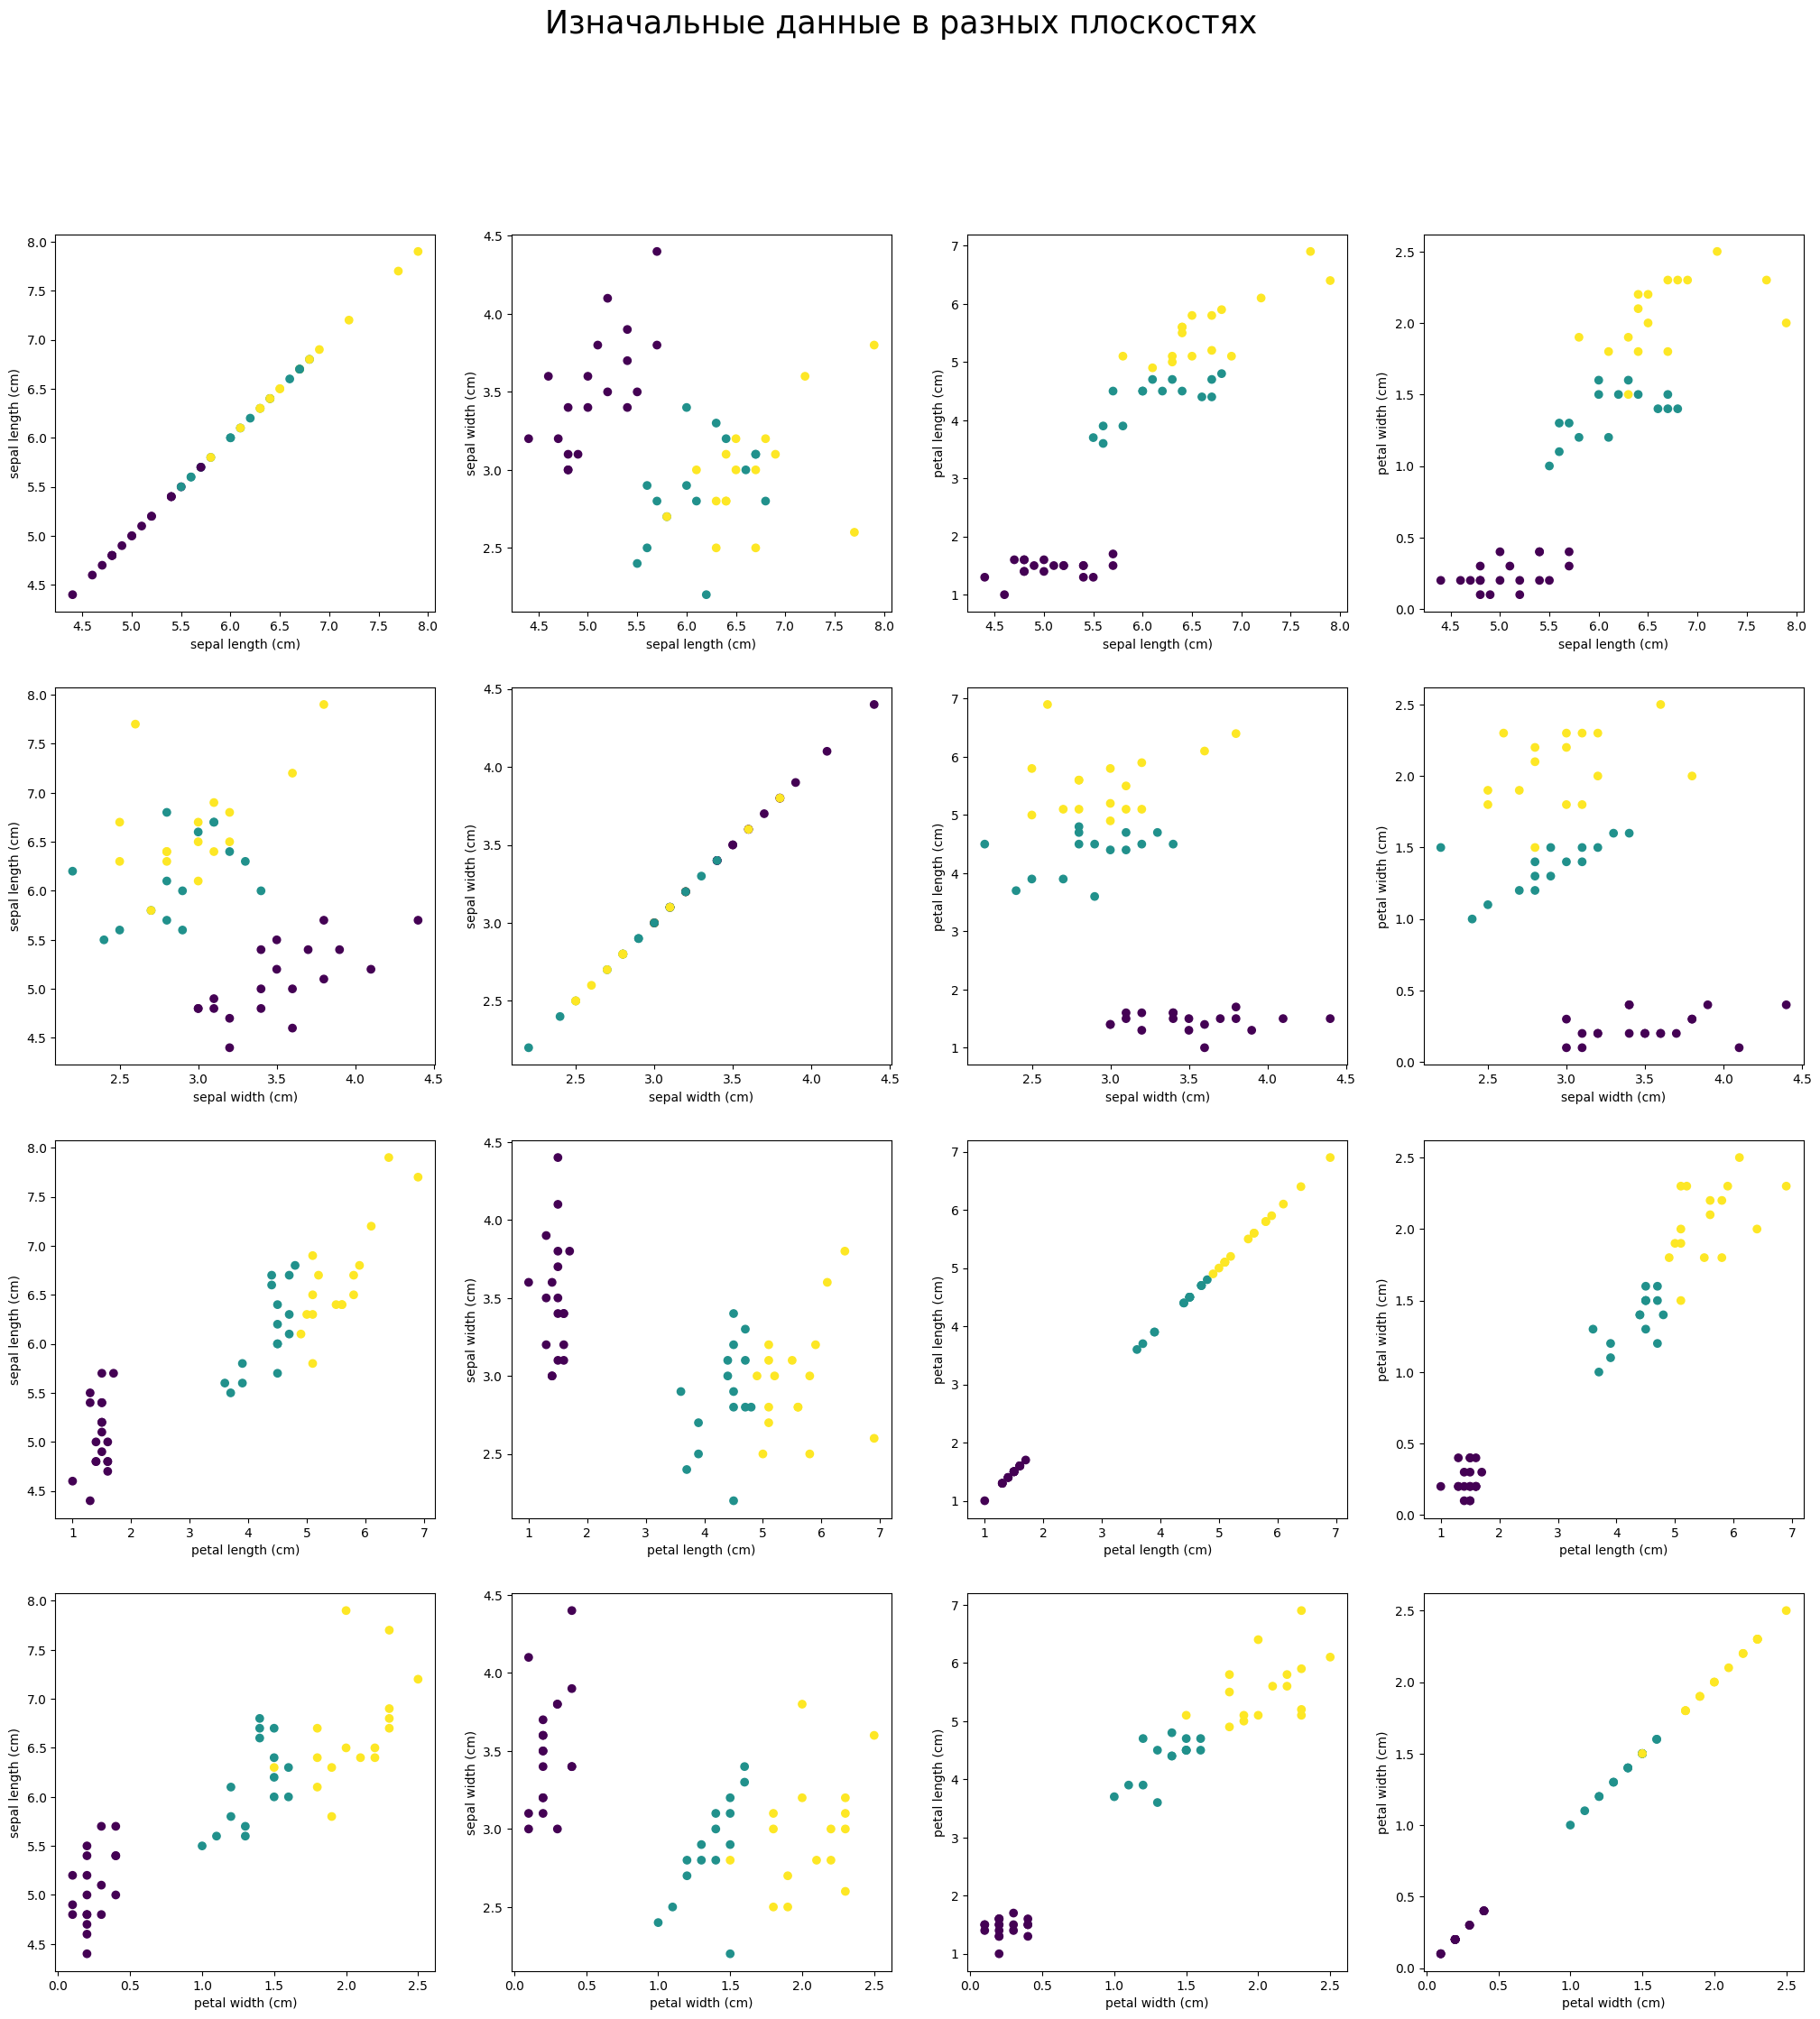

In [37]:
fig, axs = plt.subplots(figsize=(25,25), nrows= 4 , ncols= 4)
fig.suptitle('Изначальные данные в разных плоскостях',fontsize=25)
for i in range(4):
    for j in range(4):
        axs[i, j].scatter(X_test[:, i], X_test[:, j], marker='o', c=y_test)
        axs[i, j].set_xlabel(feature_names[i])
        axs[i, j].set_ylabel(feature_names[j])

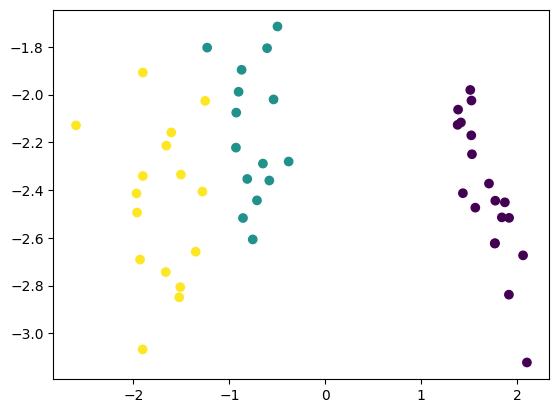

In [38]:
W = LDA_decomp(X_train, y_train, 2)
X_new = np.dot((X_test), W)
plt.scatter(X_new[:, 0], X_new[:, 1], marker='o', c=y_test)

### Уменьшение размерности с помощю sklearn

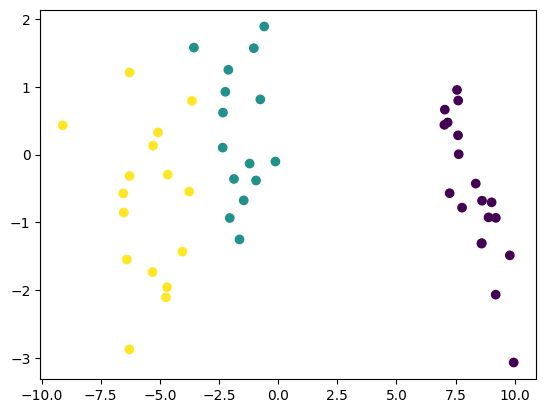

In [39]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
x_pred_lda1 = clf.transform(X_test)
plt.scatter(x_pred_lda1[:, 0], x_pred_lda1[:, 1], marker='o', c=y_test)

Если не изменять параметры в  методе LDA в sklearn`е то графики разбиения групп с написанной на семинаре функцией очень похожи.

## Рассмотрите документацию метода LDA и измените параметры классификатора таким образом, чтобы алгоритм работал эффективнее (например, поменять параметр solver). Какие параметры классификатора сильнее сказываются на конечном результате? Чем это может быть объяснимо?

Сначала попробуем поменять параметр solver - по дефолту стоит 'svd', но список всех возможных: ‘svd’, ‘lsqr’, ‘eigen’

В качестве "эффективнее" будем использвать метрику accuracy - долю верно предсказанных ответов

In [40]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred_svd = clf.predict(X_test)
print("SVD score",clf.score(X_test,y_test))

clf_lsqr = LinearDiscriminantAnalysis(solver='lsqr')
clf_lsqr.fit(X_train, y_train)
y_pred_lsqr = clf_lsqr.predict(X_test)
print("LSQR score", clf_lsqr.score(X_test,y_test))

clf_eig = LinearDiscriminantAnalysis(solver='eigen')
clf_eig.fit(X_train, y_train)
y_pred_eig= clf_eig.predict(X_test)
print("Eigen score", clf_eig.score(X_test,y_test))

SVD score 0.98
LSQR score 0.98
Eigen score 0.98


Все сработало одинаково хорошо. 

Shrinkage работает только с решателями ‘lsqr’ и ‘eigen’.

In [41]:
clf_lsqr_1 = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
clf_lsqr_1.fit(X_train, y_train)
y_pred_lsqr_1 = clf_lsqr_1.predict(X_test)
print("LSQR_1 score", clf_lsqr_1.score(X_test,y_test))

clf_eig_1 = LinearDiscriminantAnalysis(solver='eigen',shrinkage=0.9)
clf_eig_1.fit(X_train, y_train)
y_pred_eig_1= clf_eig_1.predict(X_test)
print("Eigen_1 score", clf_eig_1.score(X_test,y_test))


LSQR_1 score 0.98
Eigen_1 score 0.98


И от него в общем тоже ничего не зависит(

priors
The class prior probabilities. By default, the class proportions are inferred from the training data.

In [42]:
clf_2 = LinearDiscriminantAnalysis(priors=[0.99,0.005,0.005])
clf_2.fit(X_train, y_train)
y_pred_svd_2 = clf_2.predict(X_test)
print("SVD_2 score",clf_2.score(X_test,y_test))

clf_lsqr_2 = LinearDiscriminantAnalysis(solver='lsqr', priors=[0.9,0.05,0.05])
clf_lsqr_2.fit(X_train, y_train)
y_pred_lsqr = clf_lsqr_2.predict(X_test)
print("LSQR_2 score", clf_lsqr_2.score(X_test,y_test))

clf_eig_2 = LinearDiscriminantAnalysis(solver='eigen',priors=[0.9,0.09999999999999996,0.00000000000000001])
clf_eig_2.fit(X_train, y_train)
y_pred_eig_2= clf_eig_2.predict(X_test)
print("Eigen_2 score", clf_eig_2.score(X_test,y_test))

SVD_2 score 0.98
LSQR_2 score 0.98
Eigen_2 score 0.74


Наконец-то что-то поменялось!!!
объясняется тем, что задали очень  маленькую вероятность появления 3 класса

In [43]:
print("предсказанные моделью данные",y_pred_eig_2)
print("Реальные значения",y_test)

предсказанные моделью данные [1 0 2 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 2 0 0 0 0 1 0 0 1 1
 0 0 0 1 1 1 0 0 1 1 1 1 2]
Реальные значения [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0 1 2 2 1 2]


можно заметить, что в предсказаннных данных гораздо меньше модель определяла что-либо ко второму классу.

Можно сказать, что изменение параметров не сильно сказывается на конечном результате. Трудно привести что-то более эффективное, когда доля правильных ответов равна 0,98.

можно заметить, что ошибка предсказаний заключается в том, что вместо 3 класса был определен 2. Попробуем убрать это с помощью изменения priors

In [44]:
clf_4 = LinearDiscriminantAnalysis(priors=[0.375,0.25,0.375])
clf_4.fit(X_train, y_train)
y_pred_svd_4 = clf_4.predict(X_test)
print("SVD_4 score",clf_4.score(X_test,y_test))
print(y_pred_svd_4)

SVD_4 score 0.98
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0 1 1 2 1 2]


In [45]:
clf_4 = LinearDiscriminantAnalysis(priors=[0.45,0.1,0.45])
clf_4.fit(X_train, y_train)
y_pred_svd_4 = clf_4.predict(X_test)
print("SVD_4 score",clf_4.score(X_test,y_test))

SVD_4 score 1.0


Все ответы совпали с реальными значениями.. Но выглядит будто переобучение

# Задание 3: kNN

## Открыть датасет sklearn.datasets.load_wine, содержащий информацию о трех различных сортах вина (class0, class1, class2). Ответить на вопросы ниже, используя средства языка Python и необходимых библиотек

In [46]:
from sklearn.datasets import load_wine
wine = load_wine()
X = wine.data
y = wine.target

## Использовать три подхода к делению выборки на тренировочную и тестовую: KFold, LOO, Stratified KFold. Для воспроизводимости фиксируйте параметр random_state=42;

### KFold

In [47]:
kfold_cv = KFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, test_index) in enumerate(kfold_cv.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8  10  11  13  14  17  20  21  22  23
  25  26  27  28  32  33  34  35  36  37  38  39  40  43  44  46  47  48
  49  50  51  52  53  54  56  57  58  59  61  62  63  64  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  83  84  85  86  87  88  89  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 110
 112 115 116 120 121 122 123 124 125 126 127 129 130 131 132 133 134 135
 136 137 138 139 142 143 144 146 147 148 149 151 152 153 154 155 156 157
 158 159 160 161 162 163 165 166 167 168 170 172 173 175 176 177]
  Test:  index=[  9  12  15  16  18  19  24  29  30  31  41  42  45  55  60  65  66  67
  82  90 109 111 113 114 117 118 119 128 140 141 145 150 164 169 171 174]
Fold 1:
  Train: index=[  0   1   3   5   7   8   9  10  12  13  14  15  16  17  18  19  20  21
  23  24  25  28  29  30  31  33  34  35  37  39  40  41  42  43  44  45
  46  47  48  49  50  52  53  54  55  57  58  59  60  61  62  63  64 

### LOO

In [48]:
loo_cv = LeaveOneOut()
for i, (train_index, test_index) in enumerate(loo_cv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177]
  Test:  index=[0]
Fold 1:
  Train: index=[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  

### Stratified KFold

In [49]:
str_kfold_cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, test_index) in enumerate(str_kfold_cv.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[  2   3   4   5   6   7   8   9  10  12  13  15  18  19  20  21  22  23
  24  26  27  28  29  30  31  32  34  35  36  37  38  39  41  43  44  45
  46  47  49  50  51  52  54  55  56  57  58  59  60  61  62  63  64  66
  67  68  69  70  71  72  73  74  75  77  78  80  81  82  84  85  87  88
  91  93  94  95  96  97  98  99 100 101 102 103 104 105 106 108 110 111
 112 113 114 115 116 117 118 122 123 124 125 126 128 129 130 131 133 134
 135 136 137 138 139 141 142 143 144 147 148 149 150 151 152 153 154 155
 157 158 160 161 162 163 164 165 167 168 169 171 173 174 175 177]
  Test:  index=[  0   1  11  14  16  17  25  33  40  42  48  53  65  76  79  83  86  89
  90  92 107 109 119 120 121 127 132 140 145 146 156 159 166 170 172 176]
Fold 1:
  Train: index=[  0   1   2   4   5   6   7   8  10  11  12  13  14  16  17  18  20  21
  22  23  25  26  27  29  30  31  32  33  34  35  36  37  38  39  40  42
  43  44  45  47  48  51  53  54  56  57  58  59  60  61  63  64  65 

## Для каждого из методов кросс-валидации, а также для каждого k ∈ [1, 50] (число "соседей") прогнать алгоритм ближайших соседей (sklearn.neighbors.KNeighborsClassifier) и посчитать долю правильных ответов. Какая кросс-валидация и при каком значении k дает лучший результат?

### KFold

In [50]:
accuracy_kfold = np.zeros((50,5))

for i, (train_index, test_index) in enumerate(kfold_cv.split(X, y)):
    #print("fold",i)
    X_train, y_train,X_test, y_test = X[train_index], y[train_index],X[test_index], y[test_index]
    for j in range(1,51):
        neigh = KNeighborsClassifier(n_neighbors=j)
        neigh.fit(X_train, y_train)
        y_pred = neigh.predict(X_test)
        accuracy_kfold[j-1][i] = accuracy_score(y_test, y_pred)
        

In [51]:
# по строкам записаны accuracy для разных fold`ов кроссвалидации
# по столбцам для разного количества соседей 
print(accuracy_kfold)

[[0.77777778 0.66666667 0.72222222 0.71428571 0.77142857]
 [0.72222222 0.63888889 0.69444444 0.57142857 0.68571429]
 [0.80555556 0.61111111 0.63888889 0.65714286 0.82857143]
 [0.75       0.52777778 0.61111111 0.65714286 0.74285714]
 [0.72222222 0.61111111 0.61111111 0.68571429 0.74285714]
 [0.72222222 0.63888889 0.63888889 0.68571429 0.68571429]
 [0.69444444 0.58333333 0.72222222 0.68571429 0.71428571]
 [0.72222222 0.61111111 0.66666667 0.65714286 0.74285714]
 [0.72222222 0.63888889 0.72222222 0.68571429 0.74285714]
 [0.72222222 0.61111111 0.63888889 0.68571429 0.74285714]
 [0.75       0.63888889 0.66666667 0.71428571 0.74285714]
 [0.72222222 0.66666667 0.69444444 0.68571429 0.71428571]
 [0.72222222 0.69444444 0.66666667 0.65714286 0.71428571]
 [0.72222222 0.66666667 0.72222222 0.6        0.68571429]
 [0.75       0.72222222 0.69444444 0.62857143 0.71428571]
 [0.72222222 0.63888889 0.72222222 0.6        0.71428571]
 [0.77777778 0.72222222 0.72222222 0.6        0.68571429]
 [0.77777778 0

In [52]:
print(np.argmax(np.sum(accuracy_kfold, axis=1)/5))
print(np.sum(accuracy_kfold, axis=1)/5)


0
[0.73047619 0.66253968 0.70825397 0.65777778 0.67460317 0.67428571
 0.68       0.68       0.70238095 0.68015873 0.70253968 0.69666667
 0.69095238 0.67936508 0.70190476 0.67952381 0.7015873  0.67952381
 0.67936508 0.69095238 0.70190476 0.69650794 0.70206349 0.70761905
 0.70190476 0.69650794 0.69634921 0.70793651 0.71349206 0.70793651
 0.69095238 0.71349206 0.71349206 0.72460317 0.72460317 0.71349206
 0.71349206 0.71349206 0.70793651 0.70777778 0.71349206 0.70777778
 0.70777778 0.70777778 0.70777778 0.70777778 0.69666667 0.71904762
 0.69666667 0.70777778]


Наиулчшее значение accuracy у модели ближайшего соседа с k=1 = 0.73
Однако доля правильных предсказаний в лучшей и худшей модели отличается на 11%

### LOO

In [53]:
n_folds_loo = loo_cv.get_n_splits(X)
accuracy_loo = np.zeros((50,n_folds_loo))
for i, (train_index, test_index) in enumerate(loo_cv.split(X, y)):
    #print("fold",i)
    X_train, y_train,X_test, y_test = X[train_index], y[train_index],X[test_index], y[test_index]
    for j in range(1,51):
        neigh = KNeighborsClassifier(n_neighbors=j)
        neigh.fit(X_train, y_train)
        y_pred = neigh.predict(X_test)
        accuracy_loo[j-1][i] = accuracy_score(y_test, y_pred)

In [54]:
print(accuracy_loo)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 1.]
 ...
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 0. 1.]]


In [55]:
print(np.argmax(np.sum(accuracy_loo, axis=1)/n_folds_loo))
print(np.sum(accuracy_loo, axis=1)/n_folds_loo)


0
[0.76966292 0.6741573  0.7247191  0.66292135 0.69662921 0.68539326
 0.66292135 0.6741573  0.71348315 0.66853933 0.70786517 0.70224719
 0.69101124 0.70224719 0.70224719 0.70224719 0.69101124 0.71348315
 0.71348315 0.70224719 0.70786517 0.71910112 0.71910112 0.70786517
 0.71910112 0.71910112 0.71910112 0.71910112 0.71910112 0.71348315
 0.70786517 0.70786517 0.70786517 0.70786517 0.71910112 0.71910112
 0.7247191  0.70786517 0.70224719 0.70786517 0.70786517 0.71910112
 0.70786517 0.70786517 0.71348315 0.68539326 0.69662921 0.70786517
 0.71348315 0.70786517]


Наиулчшее значение accuracy у модели ближайшего соседа с k=1 = 0.769

### Stratified KFolds


In [56]:
n_folds_str_Kfold = str_kfold_cv.get_n_splits(X)
accuracy_str_kfold = np.zeros((50,n_folds_str_Kfold))
for i, (train_index, test_index) in enumerate(str_kfold_cv.split(X, y)):
    #print("fold",i)
    X_train, y_train,X_test, y_test = X[train_index], y[train_index],X[test_index], y[test_index]
    for j in range(1,51):
        neigh = KNeighborsClassifier(n_neighbors=j)
        neigh.fit(X_train, y_train)
        y_pred = neigh.predict(X_test)
        accuracy_str_kfold[j-1][i] = accuracy_score(y_test, y_pred)

In [57]:
print(accuracy_str_kfold)

[[0.83333333 0.72222222 0.69444444 0.65714286 0.68571429]
 [0.69444444 0.63888889 0.66666667 0.6        0.6       ]
 [0.75       0.66666667 0.72222222 0.6        0.65714286]
 [0.77777778 0.63888889 0.63888889 0.6        0.74285714]
 [0.69444444 0.61111111 0.66666667 0.74285714 0.68571429]
 [0.77777778 0.61111111 0.63888889 0.68571429 0.77142857]
 [0.77777778 0.61111111 0.63888889 0.71428571 0.65714286]
 [0.75       0.58333333 0.63888889 0.71428571 0.71428571]
 [0.69444444 0.63888889 0.69444444 0.71428571 0.68571429]
 [0.72222222 0.63888889 0.66666667 0.65714286 0.65714286]
 [0.72222222 0.66666667 0.69444444 0.68571429 0.6       ]
 [0.72222222 0.69444444 0.66666667 0.68571429 0.65714286]
 [0.72222222 0.63888889 0.69444444 0.71428571 0.71428571]
 [0.72222222 0.69444444 0.66666667 0.68571429 0.65714286]
 [0.69444444 0.69444444 0.66666667 0.71428571 0.74285714]
 [0.69444444 0.69444444 0.72222222 0.71428571 0.74285714]
 [0.69444444 0.69444444 0.63888889 0.71428571 0.68571429]
 [0.69444444 0

In [58]:
print(np.argmax(np.sum(accuracy_str_kfold, axis=1)/n_folds_str_Kfold))
print(np.sum(accuracy_str_kfold, axis=1)/n_folds_str_Kfold)

0
[0.71857143 0.64       0.67920635 0.67968254 0.68015873 0.69698413
 0.67984127 0.68015873 0.68555556 0.6684127  0.67380952 0.6852381
 0.6968254  0.6852381  0.70253968 0.71365079 0.68555556 0.68555556
 0.67412698 0.66857143 0.68       0.67428571 0.66873016 0.6684127
 0.65174603 0.6684127  0.66285714 0.6684127  0.66285714 0.6684127
 0.65730159 0.66285714 0.66285714 0.6684127  0.67396825 0.66857143
 0.67968254 0.67984127 0.71301587 0.69063492 0.70746032 0.69079365
 0.6852381  0.6852381  0.69634921 0.70174603 0.70746032 0.71301587
 0.70190476 0.70190476]


Самая большая точность достигается при k = 1, она равна 0,71. Разница  долей точности между моделями, построеными на разных наборах при таком значении, достигает 17%, что вообщеговоря не очень хорошо

In [59]:
0.83333333-0.65714286 

0.17619047

Оптимальным методом валидации является Loo, хоть он и более времязатратный по сравнению с другими кросс-валидациями, однако он дает наилучшие показатели accuracy (что логично, ведь каждая модель обучается практически на всех данных)

## Произведите масштабирование признаков с помощью функции sklearn.preprocessing.scale. Снова найдите оптимальное k на трех разных кросс-валидациях. Чему оно равно? Изменилось ли оно? Изменился ли оптимальный метод валидации?

In [60]:
scaler_standard = StandardScaler()
scaler_standard.fit(X)
X_st=scaler_standard.transform(X)
X_st

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

### KFold

In [61]:
kfold_cv_st = KFold(n_splits=5, random_state=42, shuffle=True)
n_folds_Kfold_st = str_kfold_cv.get_n_splits(X_st)

accuracy_kfold_st = np.zeros((50,n_folds_Kfold_st))

for i, (train_index, test_index) in enumerate(kfold_cv_st.split(X_st, y)):
    #print("fold",i)
    X_train, y_train,X_test, y_test = X_st[train_index], y[train_index],X_st[test_index], y[test_index]
    for j in range(1,51):
        neigh = KNeighborsClassifier(n_neighbors=j)
        neigh.fit(X_train, y_train)
        y_pred = neigh.predict(X_test)
        accuracy_kfold_st[j-1][i] = accuracy_score(y_test, y_pred)
        

In [62]:
# по строкам записаны accuracy для разных fold`ов кроссвалидации
# по столбцам для разного количества соседей 
print(accuracy_kfold_st)

[[0.94444444 0.94444444 0.91666667 0.97142857 0.94285714]
 [0.94444444 0.88888889 0.91666667 0.97142857 0.94285714]
 [0.94444444 0.94444444 0.97222222 0.97142857 0.94285714]
 [0.94444444 0.91666667 0.94444444 0.94285714 0.94285714]
 [0.94444444 0.94444444 0.97222222 0.91428571 0.97142857]
 [0.94444444 0.91666667 0.97222222 0.97142857 0.94285714]
 [0.94444444 0.91666667 0.97222222 0.94285714 0.97142857]
 [0.94444444 0.91666667 0.97222222 0.97142857 0.97142857]
 [0.94444444 0.94444444 0.97222222 0.94285714 1.        ]
 [0.94444444 0.94444444 0.97222222 0.97142857 0.97142857]
 [0.94444444 0.94444444 0.94444444 0.97142857 1.        ]
 [0.97222222 0.91666667 0.94444444 0.97142857 0.97142857]
 [0.94444444 0.94444444 0.94444444 0.91428571 1.        ]
 [0.97222222 0.94444444 0.97222222 0.97142857 0.97142857]
 [0.97222222 0.94444444 0.97222222 0.97142857 1.        ]
 [0.97222222 0.94444444 0.97222222 0.97142857 1.        ]
 [0.97222222 0.91666667 0.97222222 0.97142857 1.        ]
 [0.97222222 0

In [63]:
print(np.argmax(np.sum(accuracy_kfold_st, axis=1)/5))
print(np.sum(accuracy_kfold_st, axis=1)/5)
print((np.sum(accuracy_kfold_st, axis=1)/5)[28])
print(accuracy_kfold_st[28])

28
[0.94396825 0.93285714 0.95507937 0.93825397 0.94936508 0.94952381
 0.94952381 0.9552381  0.96079365 0.96079365 0.96095238 0.9552381
 0.94952381 0.96634921 0.97206349 0.97206349 0.96650794 0.96650794
 0.95539683 0.96650794 0.96095238 0.96650794 0.96095238 0.9552381
 0.9552381  0.96079365 0.9552381  0.96634921 0.97761905 0.96079365
 0.9552381  0.96079365 0.96634921 0.96634921 0.96079365 0.96079365
 0.9552381  0.96079365 0.96079365 0.96079365 0.96634921 0.96079365
 0.96634921 0.96063492 0.96634921 0.94952381 0.95507937 0.94952381
 0.95507937 0.96063492]
0.9776190476190475
[1.         0.94444444 0.97222222 0.97142857 1.        ]


Наиулчшее значение accuracy у модели ближайшего соседа с k=29 = 0.9776
Однако доля правильных предсказаний в лучшей и худшей модели отличается на 5.5%
Заметно сильное улучшение качества модели по сравнению с моделями, посторенными до стандартизации данных

### LOO

In [64]:
n_folds_loo_st = loo_cv.get_n_splits(X_st)
accuracy_loo_st = np.zeros((50,n_folds_loo_st))
for i, (train_index, test_index) in enumerate(loo_cv.split(X_st, y)):
    #print("fold",i)
    X_train, y_train,X_test, y_test = X_st[train_index], y[train_index],X_st[test_index], y[test_index]
    for j in range(1,51):
        neigh = KNeighborsClassifier(n_neighbors=j)
        neigh.fit(X_train, y_train)
        y_pred = neigh.predict(X_test)
        accuracy_loo_st[j-1][i] = accuracy_score(y_test, y_pred)

In [65]:
# по строкам записаны accuracy для разных fold`ов кроссвалидации
# по столбцам для разного количества соседей 
print(accuracy_loo_st)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [66]:
print(np.argmax(np.sum(accuracy_loo_st, axis=1)/n_folds_loo_st))
print(np.sum(accuracy_loo_st, axis=1)/n_folds_loo_st)
print((np.sum(accuracy_loo_st, axis=1)/n_folds_loo_st)[35])
print(accuracy_loo_st[35])

35
[0.95505618 0.94382022 0.95505618 0.9494382  0.97191011 0.96067416
 0.96629213 0.96067416 0.97191011 0.97191011 0.97752809 0.96629213
 0.96067416 0.96067416 0.96629213 0.97191011 0.96067416 0.97191011
 0.97191011 0.97191011 0.97191011 0.97191011 0.97191011 0.97191011
 0.97752809 0.97752809 0.97191011 0.97752809 0.97752809 0.97191011
 0.97191011 0.97191011 0.97191011 0.97752809 0.97752809 0.98314607
 0.98314607 0.98314607 0.98314607 0.98314607 0.98314607 0.97752809
 0.97752809 0.97191011 0.97191011 0.97191011 0.96629213 0.96629213
 0.96067416 0.96067416]
0.9831460674157303
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

Наилучшим числом соседей для стандартизированных данных при LOO валидации оказалсось k=35
При таких значениях достигается наилучший результат долей праильны ответов accuracy равный 0.983
Модель также улучшила свои показатели после стандартизвции данных 

### Stratified KFold

In [67]:
n_folds_str_Kfold_st = str_kfold_cv.get_n_splits(X)
accuracy_str_kfold_st = np.zeros((50,n_folds_str_Kfold_st))
for i, (train_index, test_index) in enumerate(str_kfold_cv.split(X_st, y)):
    #print("fold",i)
    X_train, y_train,X_test, y_test = X_st[train_index], y[train_index],X_st[test_index], y[test_index]
    for j in range(1,51):
        neigh = KNeighborsClassifier(n_neighbors=j)
        neigh.fit(X_train, y_train)
        y_pred = neigh.predict(X_test)
        accuracy_str_kfold_st[j-1][i] = accuracy_score(y_test, y_pred)

In [68]:
print(np.argmax(np.sum(accuracy_str_kfold_st, axis=1)/n_folds_str_Kfold_st))
print(np.sum(accuracy_str_kfold_st, axis=1)/n_folds_str_Kfold_st)
print((np.sum(accuracy_str_kfold_st, axis=1)/n_folds_str_Kfold_st)[12])
print(accuracy_str_kfold_st[12])

12
[0.95507937 0.94952381 0.96619048 0.9552381  0.97174603 0.95492063
 0.97190476 0.97190476 0.97190476 0.97190476 0.96619048 0.96634921
 0.97761905 0.97206349 0.96650794 0.97761905 0.97206349 0.97206349
 0.97206349 0.96650794 0.96650794 0.97206349 0.96619048 0.97190476
 0.96619048 0.96619048 0.97174603 0.97174603 0.97174603 0.97746032
 0.97746032 0.97174603 0.97746032 0.97174603 0.97190476 0.96619048
 0.96619048 0.96619048 0.97746032 0.96619048 0.97174603 0.97190476
 0.97746032 0.96634921 0.97746032 0.97190476 0.97746032 0.95507937
 0.96063492 0.96079365]
0.9776190476190475
[0.94444444 0.97222222 1.         0.97142857 1.        ]


Наилучшим числом соседей для стандартизированных данных при  stratified kfolds валидации оказалсось k=13

При таких значениях достигается наилучший результат долей праильны ответов accuracy равный 0.9776

Модель также улучшила свои показатели после стандартизации данных

Причем разница accuracy между лучшей и худшей моделью на определенных foldах равна приблизительно 6%

## Вывод 

После стандартизации данных качесто модели улучшилось для всех методов кросс-валидации. 

Также поменлись значения оптимального количества соседей в методе kNN. До стандартизации все модели предсказывали, что оптимальное количество соседей = 1, однако после модели стали показывать различные результаты: 

kfold = 29

loo = 36

stratified kfold = 13


Лучшим по значению accuracy способом кросс валидации оказался LOO, при нем доля правильных ответов достигает 0,983

Однако и другие способы хороши:  accuracy kfold = 0.9776, accuracy stratified kfold = 0.9776

Но между kfold и stratified kfold лучше использовать kfold, так как между различными моделями меньше разность в accuracy/